# Using the Source Class
In this tutorial, we'll take an in-depth look at the ``LEGWORK`` Source class and its various methods that you can use to your advantage.

In [1]:
%matplotlib inline

Let's start by importing the source module of `LEGWORK` and some other common packages.

In [2]:
from legwork import source, utils, visualisation

import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt

In [3]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.7 * fs,
          'ytick.labelsize': 0.7 * fs}
plt.rcParams.update(params)

## Instantiating a Source Class
The Source class gives you access to the majority of the functionality of `LEGWORK` from one simple class. Once a collection of sources is instantiated in this class you can calculate their strains and signal-to-noise ratios, evolve them over time and visualise their distributions or plot them on the LISA sensitivity curve.

### Basic input
Let's start by creating a random collection of possible LISA sources.

In [4]:
# create a random collection of sources
n_values = 1500
m_1 = np.random.uniform(0, 10, n_values) * u.Msun
m_2 = np.random.uniform(0, 10, n_values) * u.Msun
dist = np.random.normal(8, 1.5, n_values) * u.kpc
f_orb = 10**(-5 * np.random.power(3, n_values)) * u.Hz
ecc = 1 - np.random.power(3, n_values)

We can instantiate a `Source` class using these random sources as follows:

In [5]:
sources = source.Source(m_1=m_1, m_2=m_2, ecc=ecc, dist=dist, f_orb=f_orb, gw_lum_tol=0.05, stat_tol=1e-2,
                        interpolate_g=True)

There's a couple of things to focus on here. The masses, eccentricity and distance are all required for every source. However, you can choose to *either* supply the orbital frequency, `f_orb`, *or* the semi-major axis, `a`. Whichever you supply, the other will be immediately calculating using Kepler's third law and can be accessed immediately.

In [6]:
# the semi-major axes have been calculated
sources.a

<Quantity [0.00822514, 0.01064734, 0.00112015, ..., 0.01962235, 0.00846089,
           0.00275662] AU>

### Gravitational Wave Luminosity Tolerance

Next, we set the tolerance for the accuracy of the gravitational wave luminosity, `gw_lum_tol`, to 5%. This tolerance is used for two calculations:

1. finding the transition between "circular" and "eccentric" binaries
2. determining the number of harmonics required to capture the entire signal of a binary

Since, a more stringent tolerance will require binaries to be considered eccentric at lower eccentricities (and thus consider more than the $n = 2$ harmonic), whilst also require computing *more* harmonics in order to get the luminosity equal to the true value within the tolerance.

Let's see how this works in practice.

In [7]:
# start with a tolerance of 5%
sources.update_gw_lum_tol(0.05)
print("Eccentricity at which we consider sources to be eccentric is {:.3}".format(sources.ecc_tol),
      "for a tolerance of {:.2}".format(sources._gw_lum_tol))

# change to a tolerance of 1%
sources.update_gw_lum_tol(0.01)

print("Eccentricity at which we consider sources to be eccentric is {:.3}".format(sources.ecc_tol),
      "for a tolerance of {:.2}".format(sources._gw_lum_tol))

Eccentricity at which we consider sources to be eccentric is 0.0667 for a tolerance of 0.05
Eccentricity at which we consider sources to be eccentric is 0.0295 for a tolerance of 0.01


We can also plot the number of required harmonics for each eccentricity for different tolerances and see that you always need a greater or equal number of harmonics for a smaller tolerance.

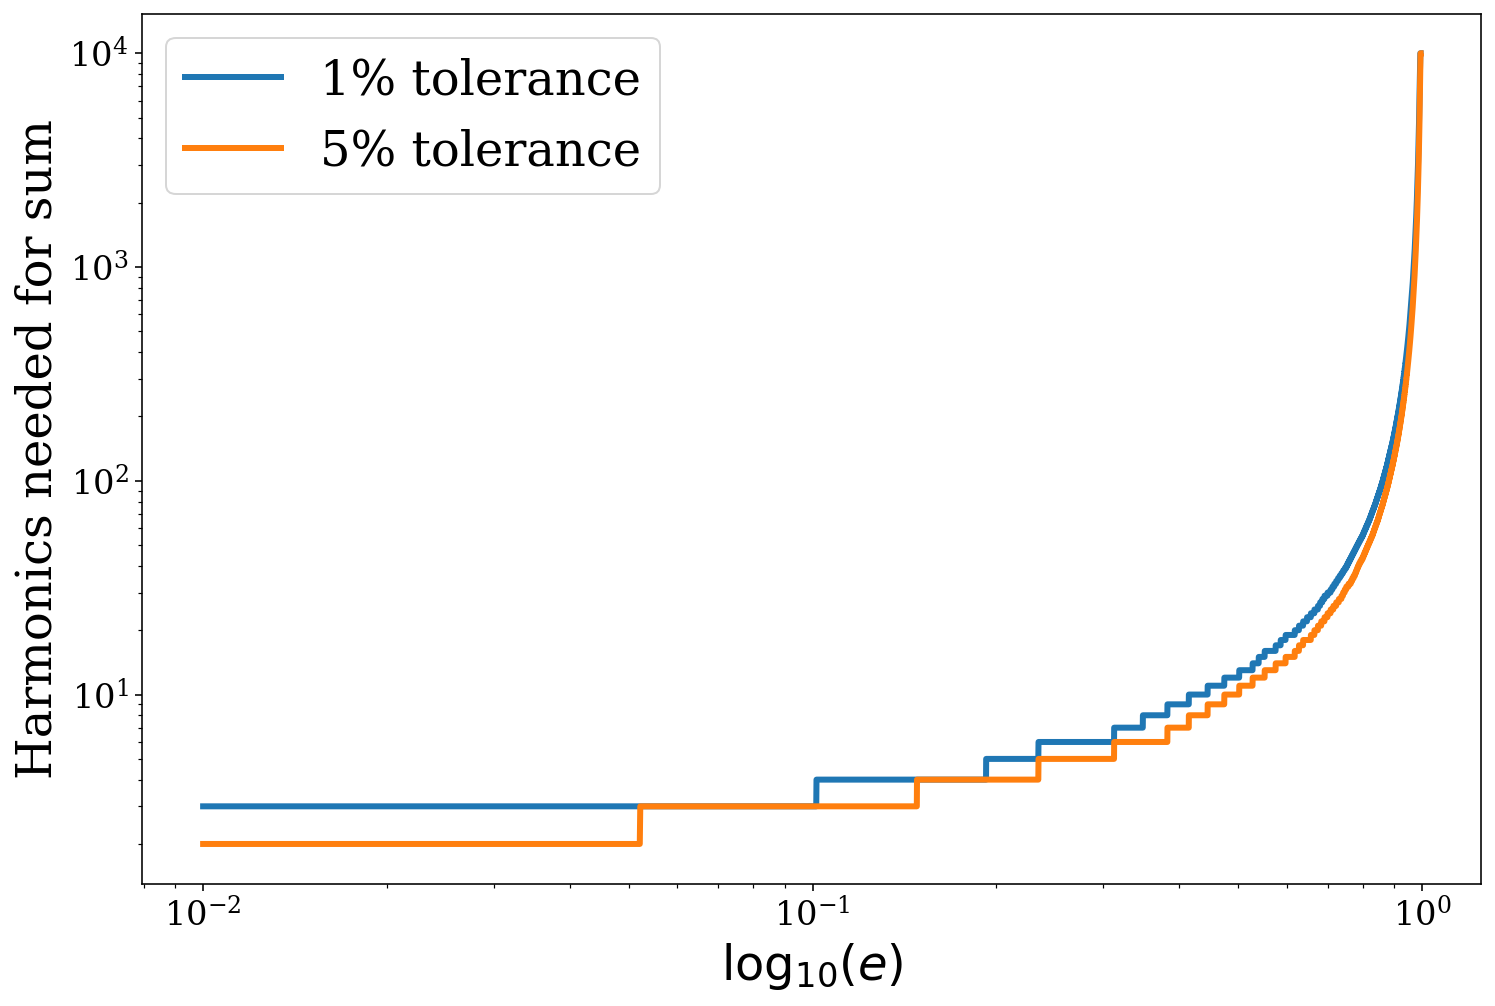

In [8]:
fig, ax = plt.subplots()
e_range = np.linspace(0.01, 0.995, 10000)

# change to a tolerance of 1%
sources.update_gw_lum_tol(0.01)
ax.loglog(e_range, sources.harmonics_required(e_range), lw=3, label="1% tolerance")

# reset to a tolerance of 5%
sources.update_gw_lum_tol(0.05)
ax.loglog(e_range, sources.harmonics_required(e_range), lw=3, label="5% tolerance")

ax.legend()

ax.set_xlabel(r"$\log_{10}(e)$")
ax.set_ylabel("Harmonics needed for sum")

plt.show()

### Stationary Tolerance

We also set the stationary tolerance in instantiating the class. This tolerance is used to determine which binaries are stationary in frequency space, and thus for which ones we can use the stationary approximation of the SNR. We define a binary as stationary in frequency space on the timescale of the LISA mission if the fractional change in orbital frequency, $\Delta f_{\rm orb} / f_{\rm orb}$, is less than or equal to the tolerance.

We can see how this changes things in practice.

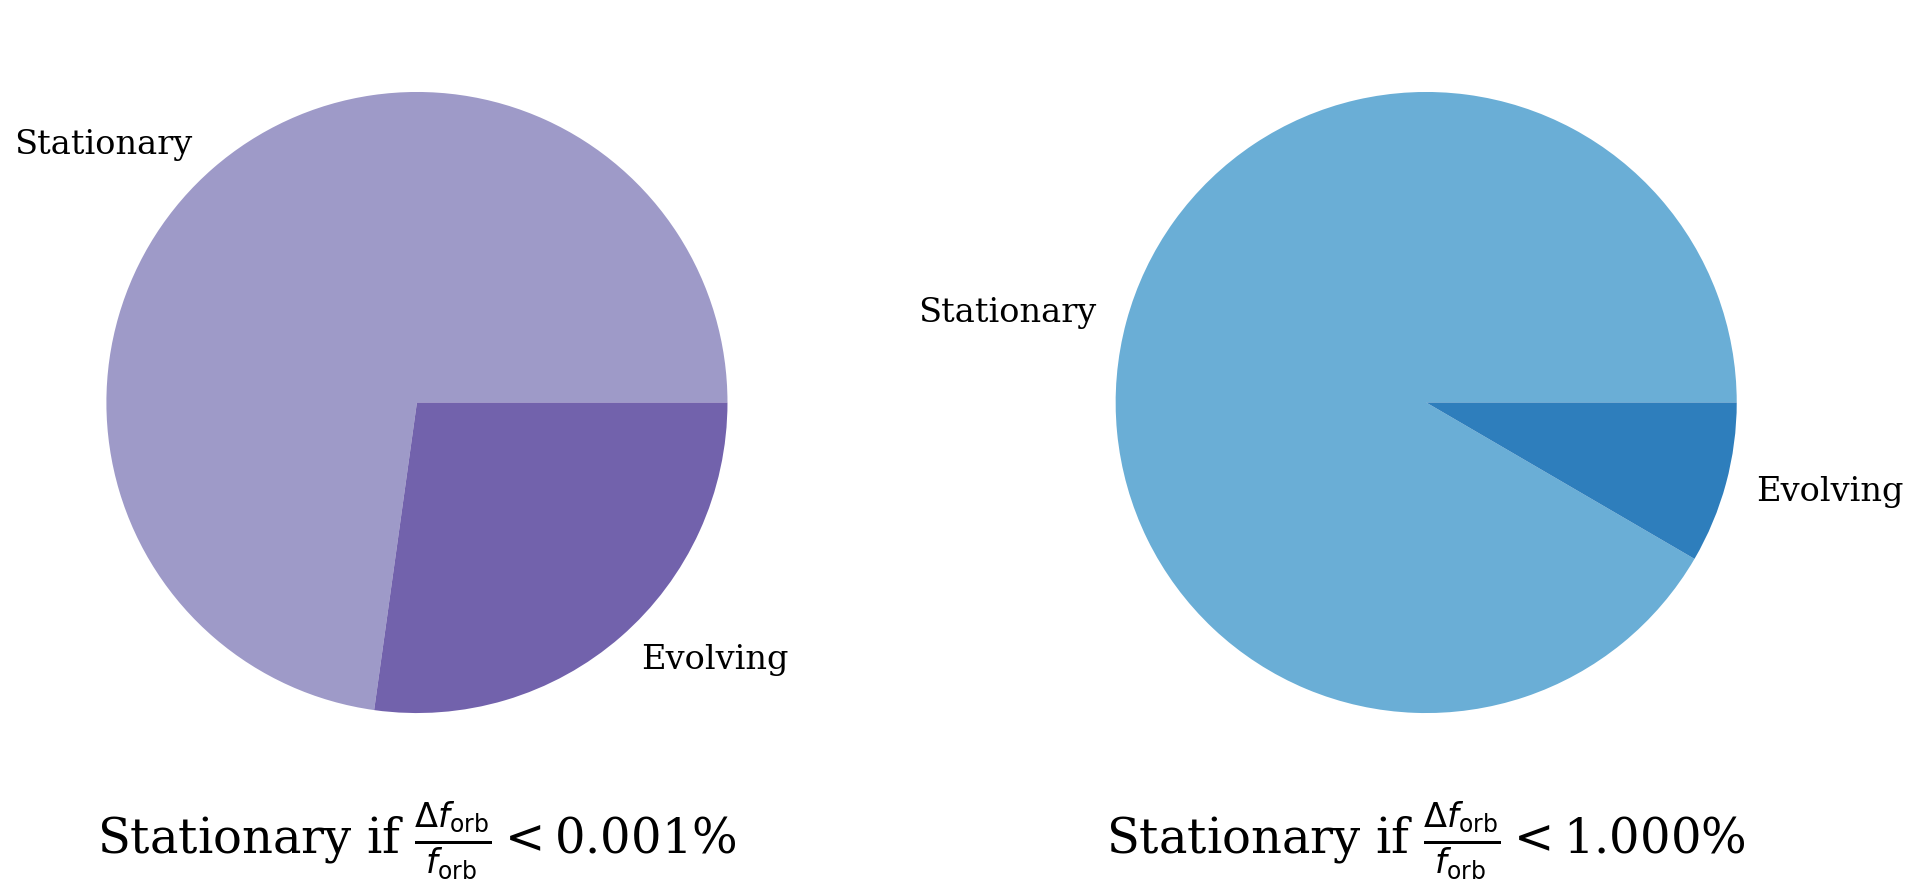

In [9]:
# create a plot
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.subplots_adjust(wspace=0.3)

# use the same labels for each
labels = ["Stationary", "Evolving"]

# loop over tolerances and colours
for i, vals in enumerate([(1e-5, "Purples"), (1e-2, "Blues")]):
    tol, col = vals
    
    # adjust the tolerance
    sources.stat_tol = tol
    
    # get a mask for the stationary binaries
    stat_mask = sources.get_source_mask(stationary=True)

    # create a pie chart
    axes[i].pie([len(stat_mask[stat_mask]), len(stat_mask[np.logical_not(stat_mask)])], labels=labels,
                colors=[plt.get_cmap(col)(0.5), plt.get_cmap(col)(0.7)])
    
    # write what the tolerance was
    axes[i].set_xlabel("Stationary if "\
                       + r"$\frac{\Delta f_{\rm orb}}{f_{\rm orb}} <$"\
                       + "{:.3f}%".format(tol * 100))

plt.show()

### $g(n,e)$ Interpolation
The last thing to consider when creating a new source class is whether to interpolate the $g(n,e)$ function from Peters (1963). This function is a complex combination of Bessel functions and thus is slow to compute. We therefore add the option to load in pre-computed $g(n,e)$ values and interpolate them instead of computing the values directly. We perform this interpolation once upon class creation and use it throughout after this. The pre-computed values span 1000 values of eccentricity and 10000 harmonics and thus are accurate for $e < 0.995$.

We can illustrate the difference in speed and results for the interpolated function vs. the real one.

In [10]:
%%timeit
e_range = np.random.uniform(0.0, 0.995, 1000)
n_range = np.arange(1, 150 + 1).astype(int)

# the argsorts here unsort the output since interp2d automatically sorts it
sources.g(n_range, e_range)[np.argsort(e_range).argsort()]

3.01 ms ± 90.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
%%timeit
e_range = np.random.uniform(0.0, 0.995, 1000)
n_range = np.arange(1, 150 + 1).astype(int)

E, N = np.meshgrid(e_range, n_range)

utils.peters_g(N, E)

1.33 s ± 45.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


You can see here that the interpolated function is **roughly 500 times faster**. Now let's ensure that they are giving the same results.

In [12]:
e_range = np.random.uniform(0.0, 0.9, 10)
n_range = np.arange(1, 150 + 1).astype(int)

g_interpolated = sources.g(n_range, e_range)[np.argsort(e_range).argsort()]

N, E = np.meshgrid(n_range, e_range)

g_true = utils.peters_g(N, E)

In [13]:
difference = np.abs(g_true - g_interpolated)
print("The largest difference between the interpolated and true value is {:.2e}".format(np.max(difference)))
print("Whilst the average difference is {:.2e}".format(np.mean(difference)))

The largest difference between the interpolated and true value is 9.44e-10
Whilst the average difference is 1.69e-11


So the functions also give pretty much the same values. However, if you happen to have a lot of computing power and time is not a factor for you then setting `interpolate_g=False` will give you more accurate results.

### Sensitivity Curve Interpolation
Similar to the previous section, we offer the ability to interpolate the sensitivity curve. The only difference is you can also pass ``sc_params`` to update the arguments that are passed to the sensitivity curve function. This provides increased speed for large samples of sources, timesteps and harmonics but will make little difference for smaller collections of sources.

## Strain and SNR calculations

### Strain functions
The source class provides a convenient wrapper around the functions from the strain module and allows you to compute either the strain or characteristic strain for any number of harmonics and any subset of the sources.

Let's try this out with the same source class instance from earlier.

In [14]:
# compute h_c_n for every source for the first four harmonics
h_c_n4 = sources.get_h_c_n([1, 2, 3, 4])
print(h_c_n4)

[[1.07710933e-17 1.00982325e-16 5.07344719e-17 1.88236488e-17]
 [2.17578263e-17 2.01329380e-16 1.02332950e-16 3.84037633e-17]
 [6.21578818e-18 8.00620340e-18 1.46189545e-17 1.68213721e-17]
 ...
 [3.61477937e-18 3.19898150e-16 1.81094490e-17 7.63609844e-19]
 [1.85869669e-17 5.98068405e-17 6.76405655e-17 5.40843168e-17]
 [4.31164145e-18 5.49131695e-17 2.08619524e-17 5.87535808e-18]]


Now imagine an (admittedly rather strange) scenario in which you only want to compute the strain for every other source. This is pretty easy to do!

In [15]:
every_other = np.array([True if i % 2 == 0 else False for i in range(sources.n_sources)])

h_0_n = sources.get_h_0_n(harmonics=[1, 2, 3, 4], which_sources=every_other)
print("The shape of this strain array is {}".format(h_0_n.shape))
print("(since we compute the first 4 harmonics and only for every other source)")

The shape of this strain array is (750, 4)
(since we compute the first 4 harmonics and only for every other source)


This may seem a little contrived but we could also use this to isolate the circular sources and compute them separately (since then we needn't bother with any harmonic except $n = 2$).

In [16]:
circular = sources.get_source_mask(circular=True)

h_c_n = sources.get_h_0_n(harmonics=2, which_sources=circular)
print("The shape of this characteristic strain array is {}".format(h_c_n.shape)),
print("(since we compute only the n=2 harmonic and only for circular sources)")

The shape of this characteristic strain array is (266, 1)
(since we compute only the n=2 harmonic and only for circular sources)


### Signal-to-Noise Ratio

This splits the sources into (up to) 4 subsets and calculates their SNRs before recollecting them and storing the result in `source.snr`.

Let's try this out. Note that we run with `verbose=True` here so that you can see the size of subpopulation.

In [17]:
snr_4 = sources.get_snr(verbose=True)

Calculating SNR for 1500 sources
	0 sources have already merged
	1374 sources are stationary
		250 sources are stationary and circular
		1124 sources are stationary and eccentric
	126 sources are evolving
		16 sources are evolving and circular
		110 sources are evolving and eccentric


We can also adjust the length of the LISA mission to see how this affects the SNR. It is also import to update the sensitivity curve parameters for the interpolation so that the interpolated sensitivity curve matches the updated mission length.

In [18]:
snr_10 = sources.get_snr(t_obs=10 * u.yr, verbose=True)

Calculating SNR for 1500 sources
	0 sources have already merged
	1350 sources are stationary
		248 sources are stationary and circular
		1102 sources are stationary and eccentric
	150 sources are evolving
		18 sources are evolving and circular
		132 sources are evolving and eccentric


Note that you can see that the number of stationary binaries has decreased slightly since some binaries may just be on the cusp of no longer being stationary and extending the time means they change frequency enough to be labelled as evolving. It could be interesting to do this to see how the number of detectable binaries changes.

In [19]:
n_detect_4 = len(snr_4[snr_4 > 7])
n_detect_10 = len(snr_10[snr_10 > 7])
print("{} binaries are detectable over 4 years".format(n_detect_4))
print("Whilst extending to a 10 year mission gives {}".format(n_detect_10))

588 binaries are detectable over 4 years
Whilst extending to a 10 year mission gives 632


#### Position-inclination-polarisation specfic sources

For some sources, you may already know the positions and this means that you can use a more specific SNR calculation (see the derivations for more details) rather than an average.

We can input this when instantiating the source. For positions we use the Skycoord Class from Astropy, which allows you to specific the coordinates in any frame and it will automatically convert it to the necessary coordinates in LEGWORK.

In [27]:
sources_specific = source.Source(m_1=m_1, m_2=m_2, f_orb=f_orb, dist=dist, ecc=np.repeat(0.0, len(m_1)),
                                 position=SkyCoord(lon=np.random.uniform(0, 2 * np.pi) * u.rad,
                                                   lat=np.random.uniform(-np.pi / 2, np.pi / 2) * u.rad,
                                                   distance=dist, frame="heliocentrictrueecliptic"),
                                 inclination=np.arcsin(np.random.uniform(-1, 1, len(m_1))) * u.rad,
                                 polarisation=np.random.uniform(0, 2 * np.pi, len(m_1)) * u.rad)
sources_specific.get_snr()

array([7.09626714e-02, 5.77903899e-06, 8.27655092e-02, ...,
       3.00081168e-05, 6.55788956e-06, 2.83464531e-07])

In [28]:
sources_average = source.Source(m_1=m_1, m_2=m_2, f_orb=f_orb, dist=dist, ecc=np.repeat(0.0, len(m_1)))
sources_average.get_snr()

array([9.58838461e-02, 1.21455731e-05, 1.65429841e-01, ...,
       3.92677857e-05, 8.88227529e-06, 3.73274006e-07])

Let's plot the ratio of the SNR for the two cases using the visualisation module.

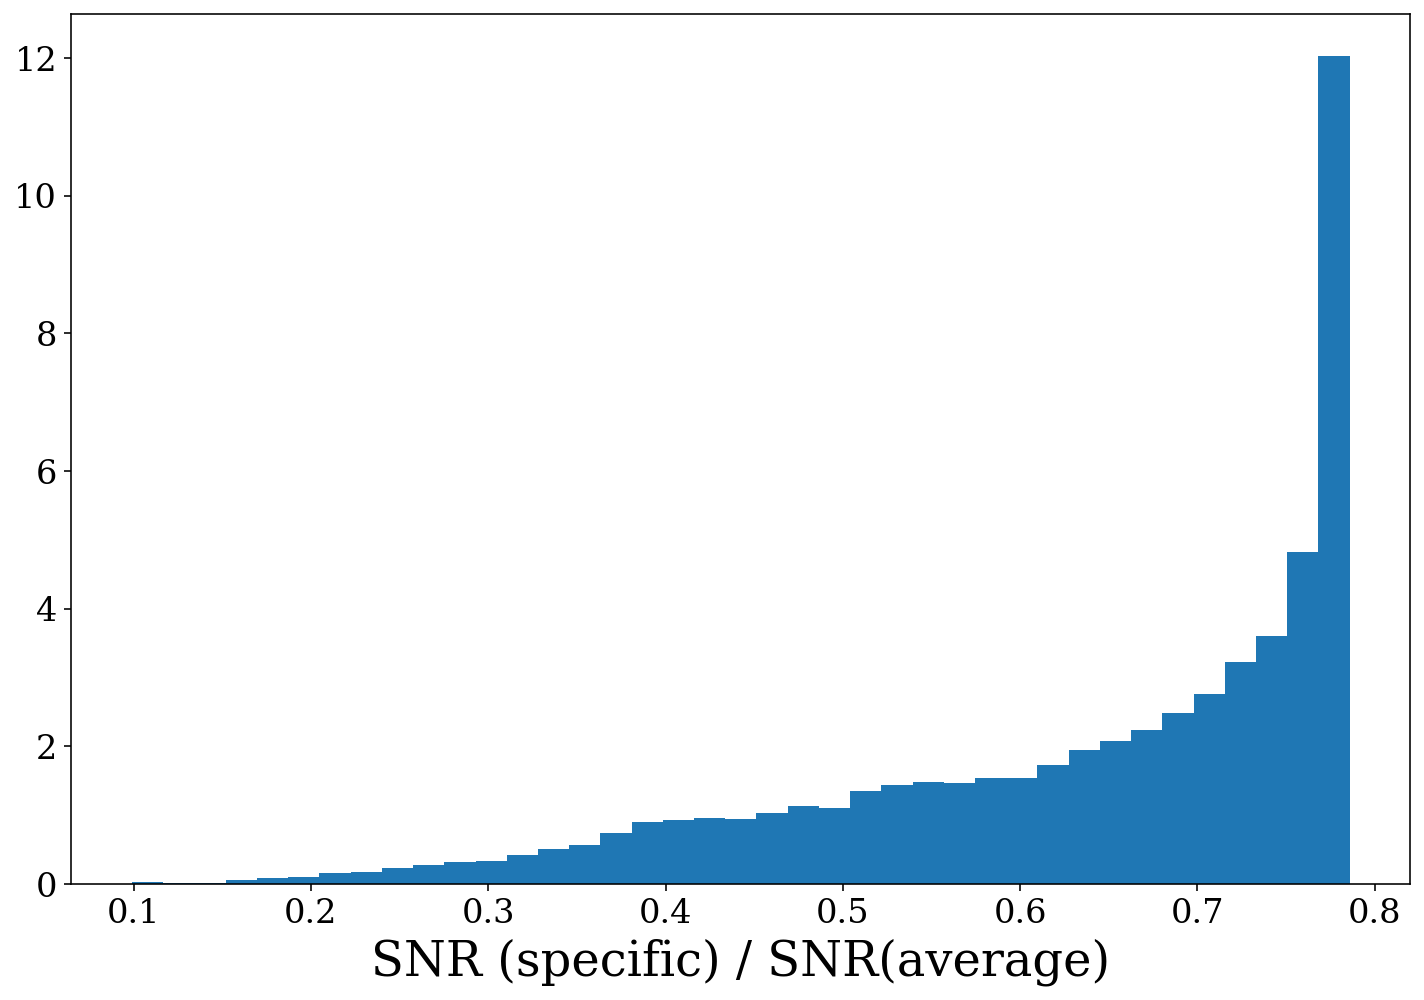

In [29]:
snr_ratio = sources_specific.snr / sources_average.snr
fig, ax = visualisation.plot_1D_dist(snr_ratio, bins="fd", xlabel="SNR (specific) / SNR(average)")

As you can see, the SNR for a specific source is always lower than for the average source. This is because the modulation reduces the strain amplitude as the smearing in frequency reduces the amount of signal build up at the true source frequency. 

## Visualisation
Although the visualisation model gives more freedom in honing various aspects of your plots, for general analysis the source class has two functions to quickly create plots to investigate distributions.

### Parameters Distributions

In [23]:
# create a random collection of sources
n_values = 15000
m_1 = np.random.uniform(0, 10, n_values) * u.Msun
m_2 = np.random.uniform(0, 10, n_values) * u.Msun
dist = np.random.normal(8, 1.5, n_values) * u.kpc
f_orb = 10**(np.random.normal(-5, 0.5, n_values)) * u.Hz
ecc = 1 - np.random.power(3, n_values)

sources = source.Source(m_1=m_1, m_2=m_2, ecc=ecc, dist=dist, f_orb=f_orb)

This function will let you plot any of several parameters (listed in the table below) and work out the units for the axes labels automatically based on the values in the source class.

| Parameter                    | Label |
|------------------------------|:-----:|
| Primary Mass                 | m_1   |
| Secondary Mass               | m_2   |
| Chirp Mass                   | m_c   |
| Eccentricity                 | ecc   |
| Distance                     | dist  |
| Orbital Frequency            | f_orb |
| Gravitational Wave Frequency | f_GW  |
| Semi-major Axis              | a     |
| Signal-to-noise Ratio        | snr   |

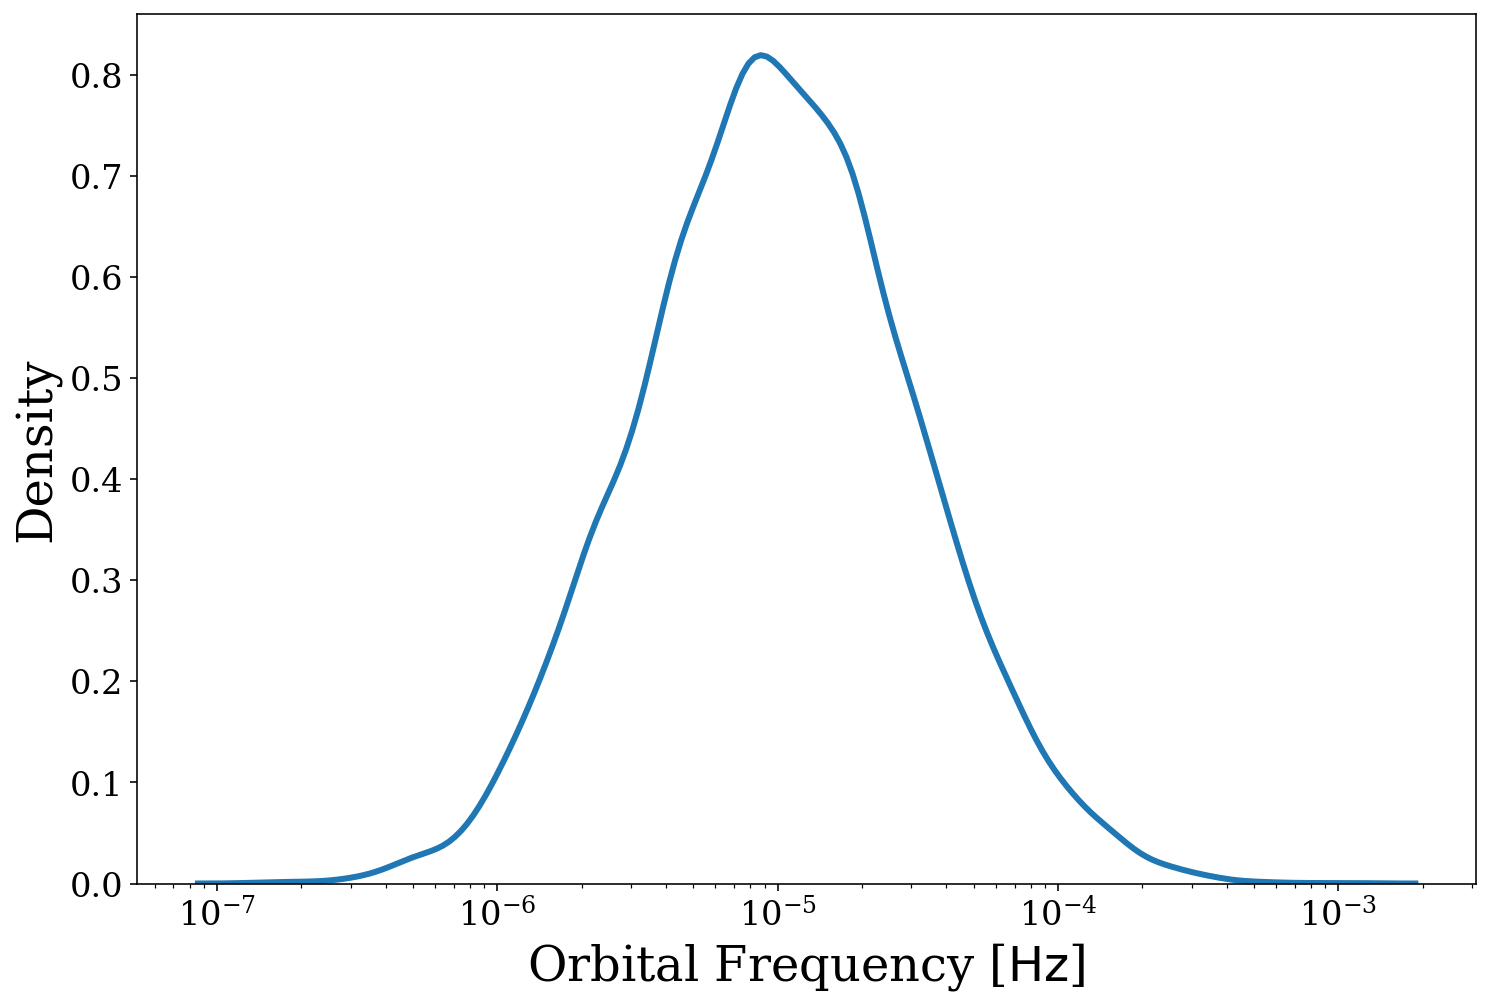

In [24]:
fig, ax = sources.plot_source_variables(xstr="f_orb", disttype="kde", log_scale=True, linewidth=3)

But we could also try to see how the detectable population is different from the entire population. Let's create two frequency KDEs, one for the detectable binaries and another for all of them. For this we will use the `which_sources` parameter and pass a mask on the SNR.

Calculating SNR for 15000 sources
	0 sources have already merged
	15000 sources are stationary
		2850 sources are stationary and circular
		12150 sources are stationary and eccentric


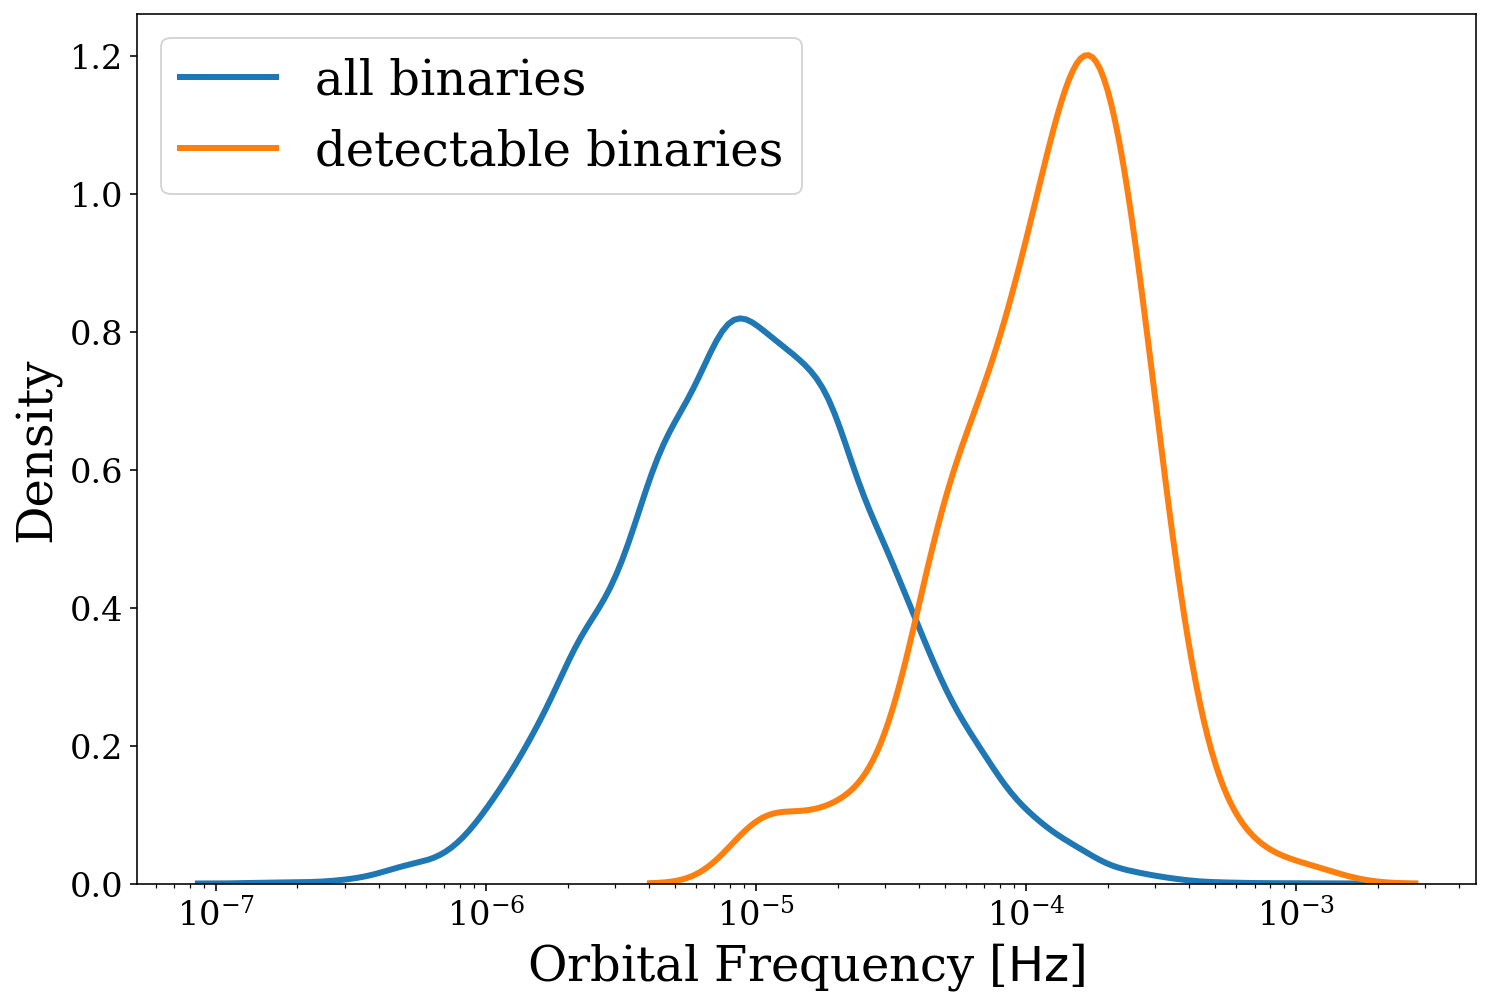

In [25]:
# calculate the SNR
snr = sources.get_snr(verbose=True)

# mask detectable binaries
detectable = snr > 7

# plot all binaries
fig, ax = sources.plot_source_variables(xstr="f_orb", disttype="kde", log_scale=True, linewidth=3,
                                        show=False, label="all binaries")

# plot all binaries
fig, ax = sources.plot_source_variables(xstr="f_orb", disttype="kde", log_scale=True, linewidth=3, fig=fig,
                                        ax=ax, which_sources=detectable, label="detectable binaries",
                                        show=False)

ax.legend()

plt.show()

Here's we can see that the distribution is shifted to higher frequencies for detectable binaries which makes sense since these are easier to detect.

### Sources on the Sensitivity Curve

Here we set `snr_cutoff=7` so that only binaries with SNR > 7 are plotted and switch the `disttype` to a KDE density plot. The circular binaries are plotted in blue and the eccentric binaries in orange.

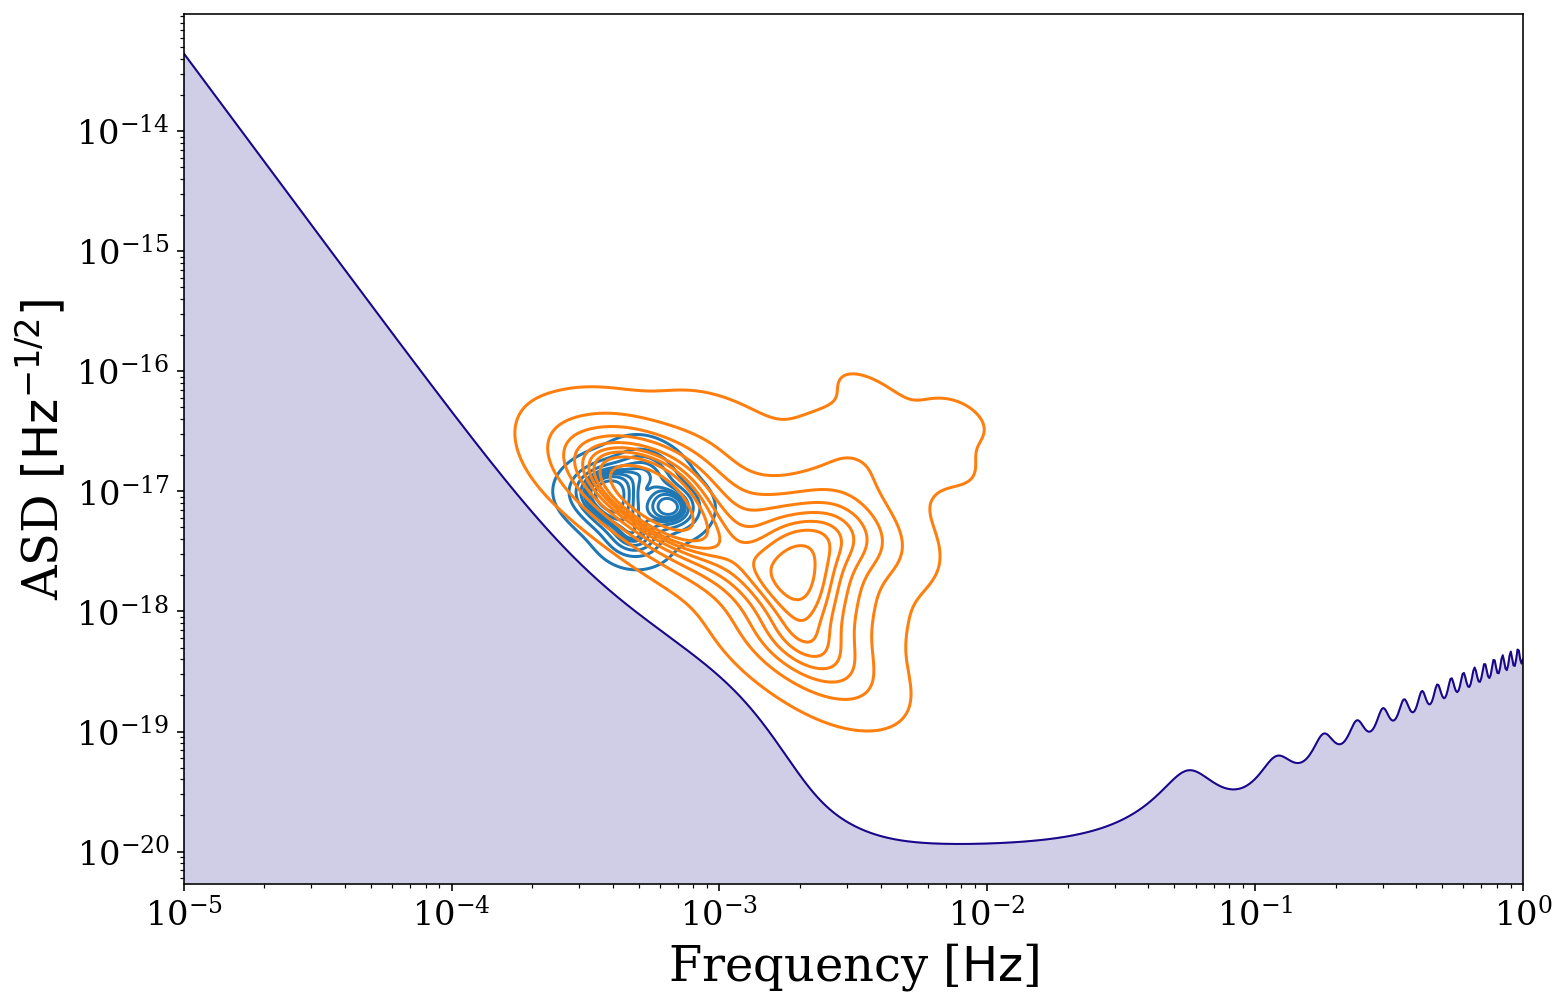

In [26]:
fig, ax = sources.plot_sources_on_sc(snr_cutoff=7, disttype="kde")

That's all for this tutorial, be sure to check out [the other ones](../tutorials.rst) to find *other* ways to keep your feet up and let us do the `LEGWORK`!